In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
!pip install xgboost
import xgboost as xgb




In [3]:
!pip install catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


In [4]:
df=pd.read_csv("/content/sample_data/bank-additional-full.csv",sep=';')

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.drop(df[(df["duration"]==0)].index,inplace=True)

In [7]:
df['euribor3m*emp.var.rate*nr.employed']=df["euribor3m"]*df["emp.var.rate"]*df["nr.employed"]

In [8]:
df.drop(["euribor3m","nr.employed","emp.var.rate"],axis=1,inplace=True)

In [9]:
df[["job","marital","loan","default","housing","education"]]=df[["job","marital","loan","default","housing","education"]].replace("unknown",np.NaN)

In [10]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder


categorical_cols = df.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))


imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)
df_clean_imputed = imputer.fit_transform(df)

df_clean_imputed = pd.DataFrame(df_clean_imputed, columns=df.columns)
print(df_clean_imputed.head())


    age  job  marital  education  default  housing  loan  contact  month  \
0  56.0  3.0      1.0        0.0      1.0      1.0   1.0      1.0    6.0   
1  57.0  8.0      1.0        3.0      0.0      1.0   1.0      1.0    6.0   
2  37.0  8.0      1.0        3.0      1.0      2.0   1.0      1.0    6.0   
3  40.0  0.0      1.0        1.0      1.0      1.0   1.0      1.0    6.0   
4  56.0  8.0      1.0        3.0      1.0      1.0   2.0      1.0    6.0   

   day_of_week  duration  campaign  pdays  previous  poutcome  cons.price.idx  \
0          1.0     261.0       1.0  999.0       0.0       1.0          93.994   
1          1.0     149.0       1.0  999.0       0.0       1.0          93.994   
2          1.0     226.0       1.0  999.0       0.0       1.0          93.994   
3          1.0     151.0       1.0  999.0       0.0       1.0          93.994   
4          1.0     307.0       1.0  999.0       0.0       1.0          93.994   

   cons.conf.idx    y  euribor3m*emp.var.rate*nr.employe

In [11]:
df=df_clean_imputed

In [12]:
X=df.drop("y",axis=1)
y=df["y"]

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [14]:
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [15]:
from collections import Counter

class_counts = Counter(y_train)
total_samples = len(y_train)

weights = {cls: total_samples / count for cls, count in class_counts.items()}
print("Sınıf Ağırlıkları:", weights)

Sınıf Ağırlıkları: {0.0: 1.1263593461459545, 1.0: 8.913937753721244}


# **Models**

**Base-Model**


Confusion Matrix:
[[7123  168]
 [ 592  352]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      7291
         1.0       0.68      0.37      0.48       944

    accuracy                           0.91      8235
   macro avg       0.80      0.67      0.72      8235
weighted avg       0.90      0.91      0.90      8235


ROC AUC Score: 0.93


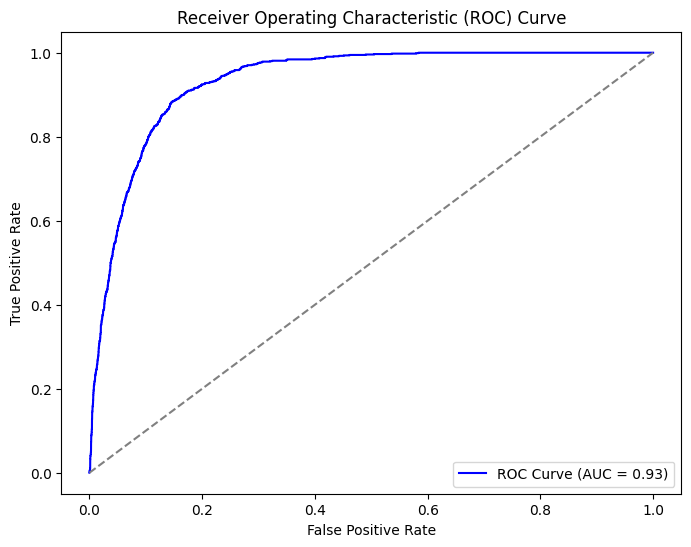

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train_scaled, y_train)


y_pred = svm_clf.predict(X_test_scaled)
y_prob = svm_clf.predict_proba(X_test_scaled)[:, 1]


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**SVM-Weight Class**

Accuracy: 0.8019

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      7291
         1.0       0.36      0.96      0.53       944

    accuracy                           0.80      8235
   macro avg       0.68      0.87      0.70      8235
weighted avg       0.92      0.80      0.83      8235


Confusion Matrix:
[[5702 1589]
 [  42  902]]


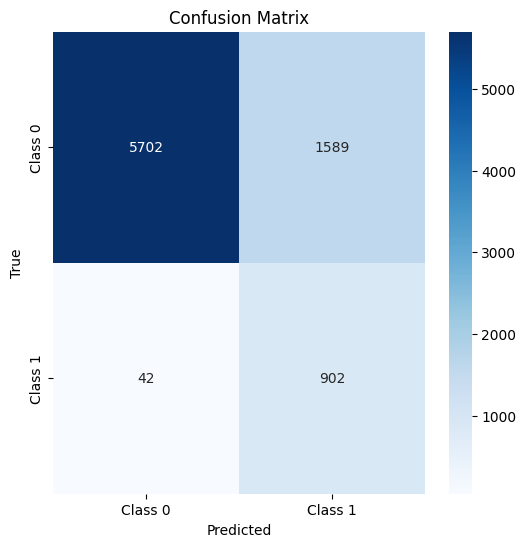

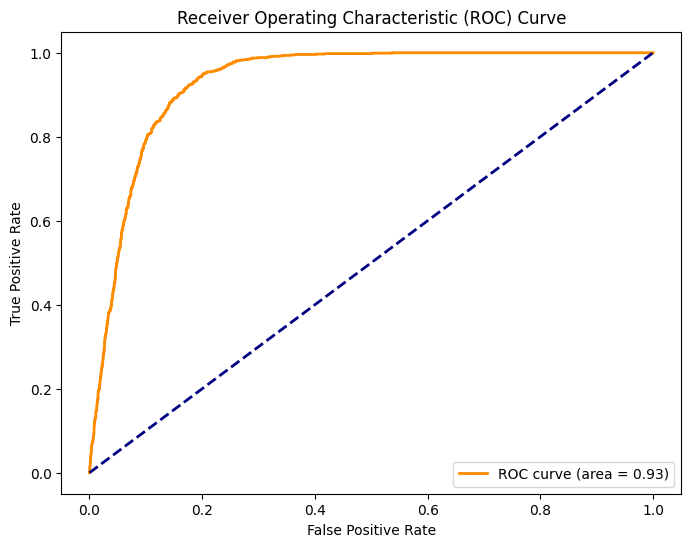


Tuned Model Accuracy: 0.8086

Tuned Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      7291
         1.0       0.37      0.93      0.53       944

    accuracy                           0.81      8235
   macro avg       0.68      0.86      0.70      8235
weighted avg       0.92      0.81      0.84      8235


Tuned Confusion Matrix:
[[5781 1510]
 [  66  878]]


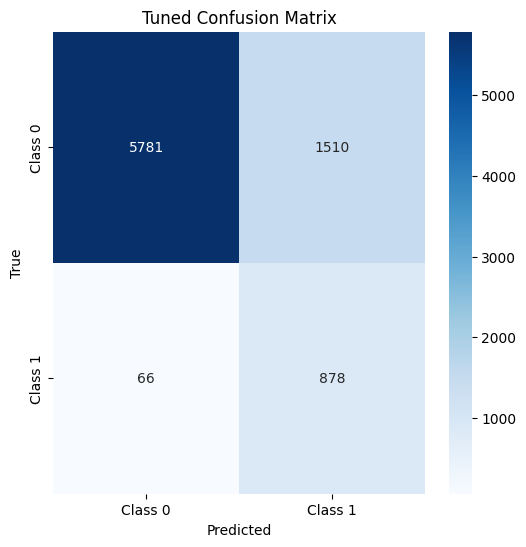

In [17]:

clf = SVC(class_weight={0: weights[0], 1: weights[1]}, random_state=42)
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, clf.decision_function(X_test_scaled))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

clf_tuned = SVC(class_weight={0: weights[0], 1: weights[1]}, C=10, kernel='rbf', random_state=42)
clf_tuned.fit(X_train_scaled, y_train)

y_pred_tuned = clf_tuned.predict(X_test_scaled)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned Model Accuracy: {accuracy_tuned:.4f}")

print("\nTuned Classification Report:")
print(classification_report(y_test, y_pred_tuned))

conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nTuned Confusion Matrix:")
print(conf_matrix_tuned)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Tuned Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**SVM-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Class distribution after SMOTE: [29242 29242]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      7291
         1.0       0.37      0.94      0.53       944

    accuracy                           0.81      8235
   macro avg       0.68      0.87      0.70      8235
weighted avg       0.92      0.81      0.84      8235

Confusion Matrix:
 [[5770 1521]
 [  57  887]]
ROC AUC Score: 0.9283039049768812


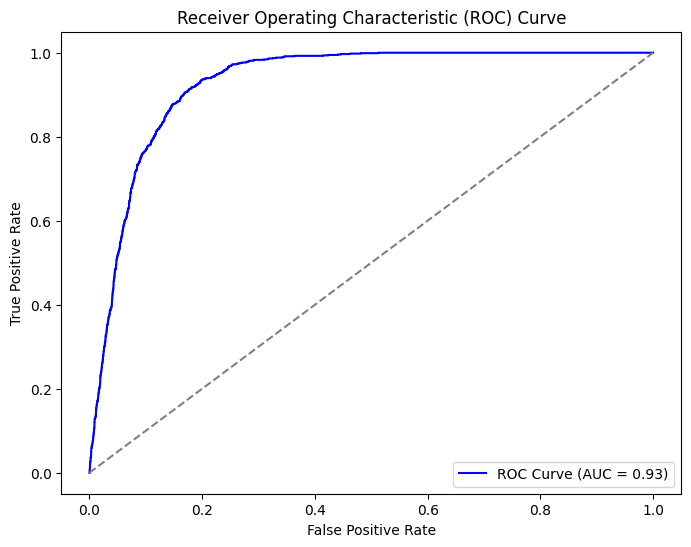

In [18]:

from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Class distribution after SMOTE: {np.bincount(y_resampled)}")

svm_clf = SVC(kernel='rbf',class_weight="balanced", C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_resampled, y_resampled)

y_pred = svm_clf.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

y_prob = svm_clf.decision_function(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**BaggingClassifier-SVM**

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

svm_clf = SVC(kernel='rbf', class_weight='balanced', random_state=42)

ensemble_svm = BaggingClassifier(estimator=svm_clf, n_estimators=10, random_state=42)

ensemble_svm.fit(X_train_scaled, y_train)

y_pred = ensemble_svm.predict(X_test_scaled)


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Confusion Matrix:
[[5736 1555]
 [  42  902]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      7291
         1.0       0.37      0.96      0.53       944

    accuracy                           0.81      8235
   macro avg       0.68      0.87      0.70      8235
weighted avg       0.92      0.81      0.84      8235



**SVM-RandomUnderSampler**

Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



Confusion Matrix:
[[5712 1579]
 [  47  897]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.88      7291
         1.0       0.36      0.95      0.52       944

    accuracy                           0.80      8235
   macro avg       0.68      0.87      0.70      8235
weighted avg       0.92      0.80      0.84      8235


ROC AUC Score: 0.94


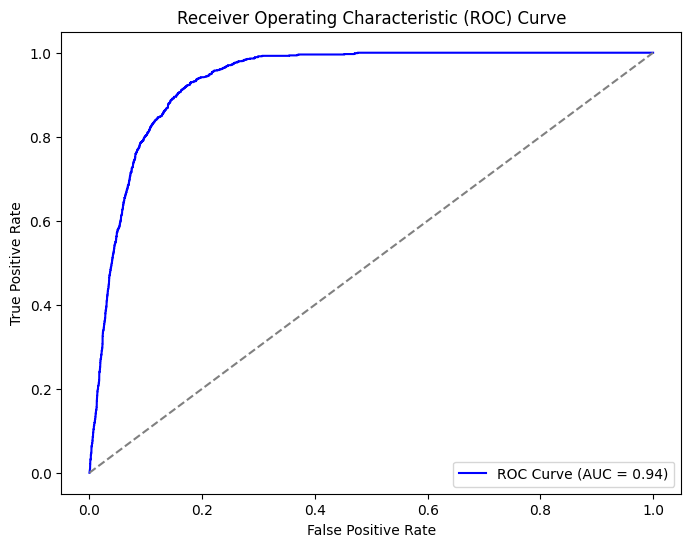

In [20]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

svc_clf = SVC(kernel='rbf', probability=True, random_state=42)
svc_clf.fit(X_resampled, y_resampled)

y_pred = svc_clf.predict(X_test_scaled)
y_prob = svc_clf.predict_proba(X_test_scaled)[:, 1]


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Svm-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTE+ENN sonrası sınıf dağılımı: [23604 27310]

Confusion Matrix:
[[5619 1672]
 [  38  906]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87      7291
         1.0       0.35      0.96      0.51       944

    accuracy                           0.79      8235
   macro avg       0.67      0.87      0.69      8235
weighted avg       0.92      0.79      0.83      8235


ROC AUC Score: 0.93


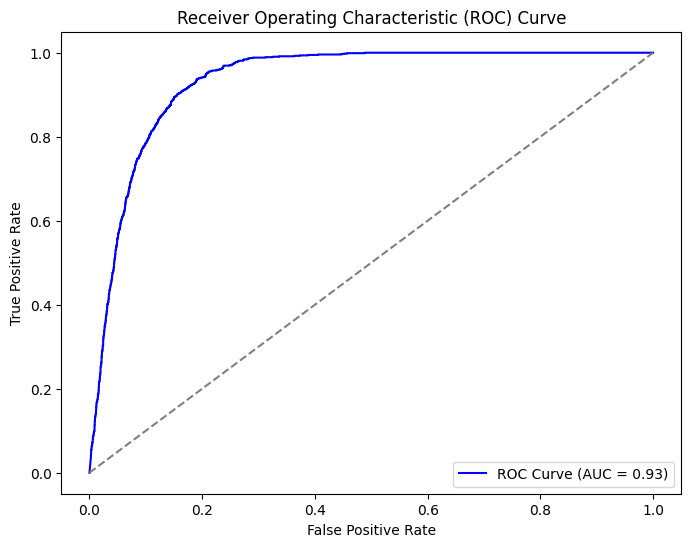

In [21]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE+ENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

svc_clf = SVC(kernel='rbf', probability=True, random_state=42)
svc_clf.fit(X_resampled, y_resampled)

y_pred = svc_clf.predict(X_test_scaled)
y_prob = svc_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression Weighted Class**

Accuracy: 0.7985

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      7291
         1.0       0.36      0.94      0.52       944

    accuracy                           0.80      8235
   macro avg       0.67      0.86      0.70      8235
weighted avg       0.92      0.80      0.83      8235


Confusion Matrix:
[[5684 1607]
 [  52  892]]


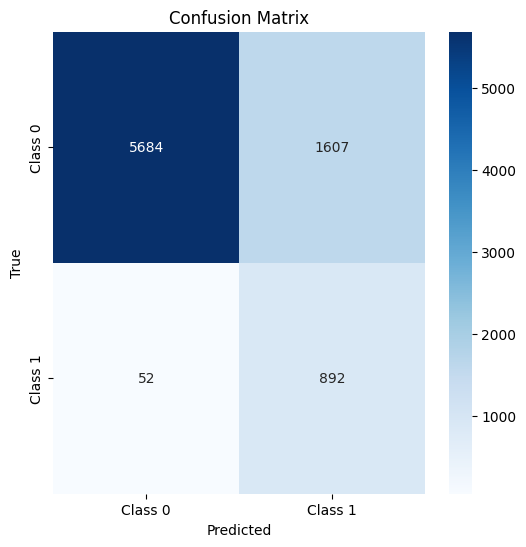

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


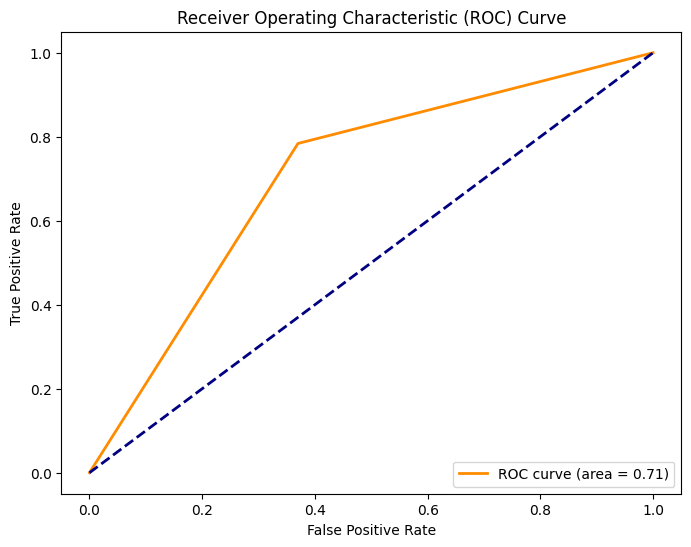


Tuned Model Accuracy: 0.7973

Tuned Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      7291
         1.0       0.36      0.95      0.52       944

    accuracy                           0.80      8235
   macro avg       0.67      0.86      0.69      8235
weighted avg       0.92      0.80      0.83      8235


Tuned Confusion Matrix:
[[5673 1618]
 [  51  893]]


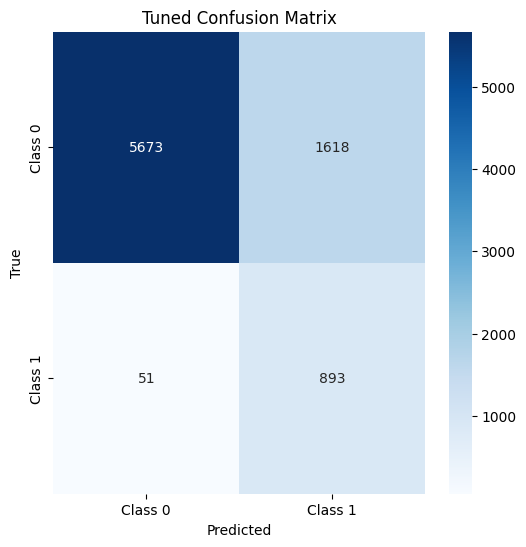

In [22]:

log_reg = LogisticRegression(class_weight={0: weights[0], 1: weights[1]}, random_state=42, solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

log_reg_tuned = LogisticRegression(class_weight={0:weights[0], 1: weights[1] }, random_state=42, C=10, solver='liblinear')
log_reg_tuned.fit(X_train_scaled, y_train)

y_pred_tuned = log_reg_tuned.predict(X_test_scaled)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned Model Accuracy: {accuracy_tuned:.4f}")

print("\nTuned Classification Report:")
print(classification_report(y_test, y_pred_tuned))

conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nTuned Confusion Matrix:")
print(conf_matrix_tuned)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Tuned Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Logistic Regression-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[5738 1553]
 [  61  883]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      7291
         1.0       0.36      0.94      0.52       944

    accuracy                           0.80      8235
   macro avg       0.68      0.86      0.70      8235
weighted avg       0.92      0.80      0.84      8235


ROC AUC Score: 0.93


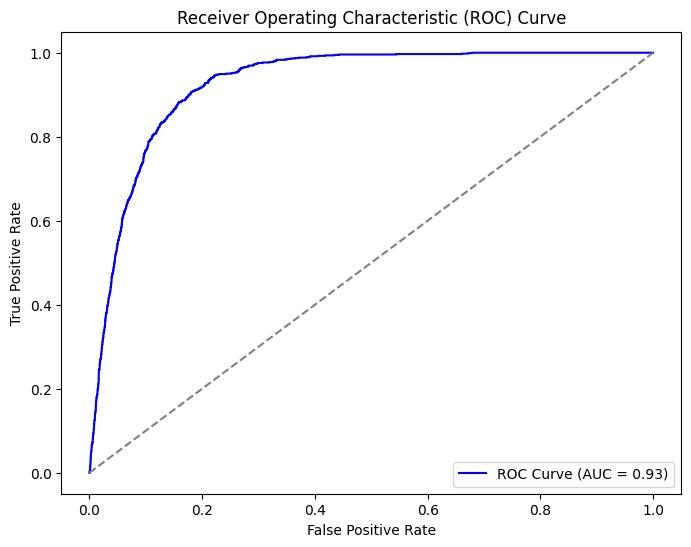

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(class_weight="balanced",solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-BaggingClassifier**


Confusion Matrix:
[[5640 1651]
 [  55  889]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87      7291
         1.0       0.35      0.94      0.51       944

    accuracy                           0.79      8235
   macro avg       0.67      0.86      0.69      8235
weighted avg       0.92      0.79      0.83      8235


ROC AUC Score: 0.93


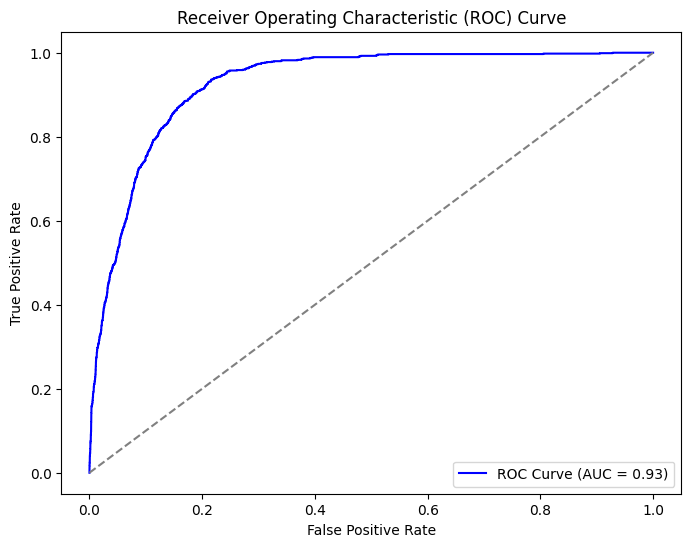

In [24]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve




base_model = LogisticRegression(class_weight={0:weights[0], 1: weights[1] },solver='liblinear', random_state=42)
ensemble_model = BaggingClassifier(
    estimator=base_model,
    n_estimators=10,
    random_state=42,
    max_samples=0.8,
    max_features=0.8
)

ensemble_model.fit(X_train_scaled, y_train)

y_pred = ensemble_model.predict(X_test_scaled)
y_prob = ensemble_model.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression-RandomUnderSampling**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[5715 1576]
 [  60  884]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      7291
         1.0       0.36      0.94      0.52       944

    accuracy                           0.80      8235
   macro avg       0.67      0.86      0.70      8235
weighted avg       0.92      0.80      0.83      8235


ROC AUC Score: 0.93


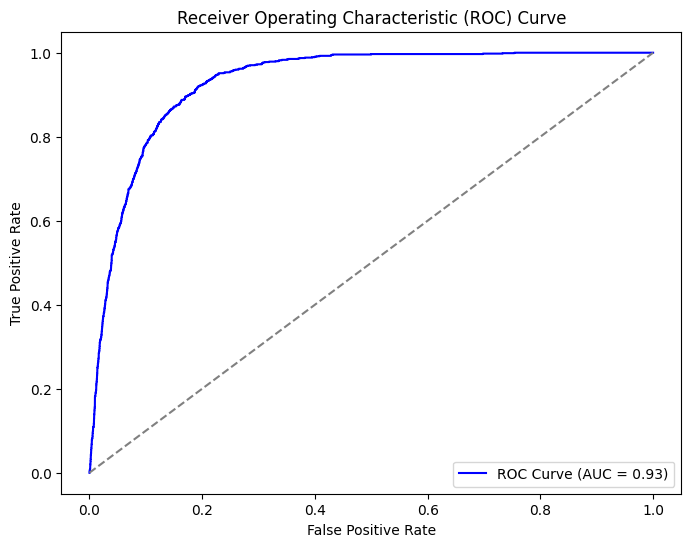

In [25]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



**Logistic Regression-Smoteen**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Original Class Distribution: [29242  3695]
 After SMOTEENN: [23604 27310]

Confusion Matrix:
[[5518 1773]
 [  45  899]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      7291
         1.0       0.34      0.95      0.50       944

    accuracy                           0.78      8235
   macro avg       0.66      0.85      0.68      8235
weighted avg       0.92      0.78      0.82      8235


ROC AUC Score: 0.93


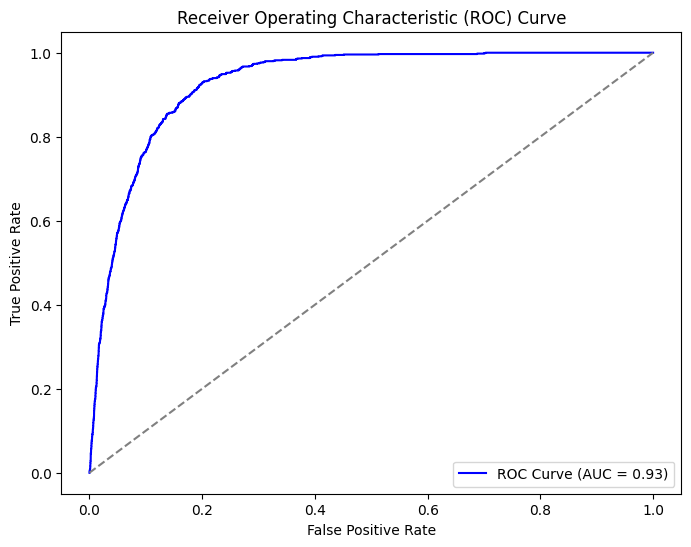

In [26]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Original Class Distribution: {np.bincount(y_train)}")
print(f" After SMOTEENN: {np.bincount(y_resampled)}")

log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]  # Pozitif sınıf için olasılıklar

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBoost-Weighted Class**

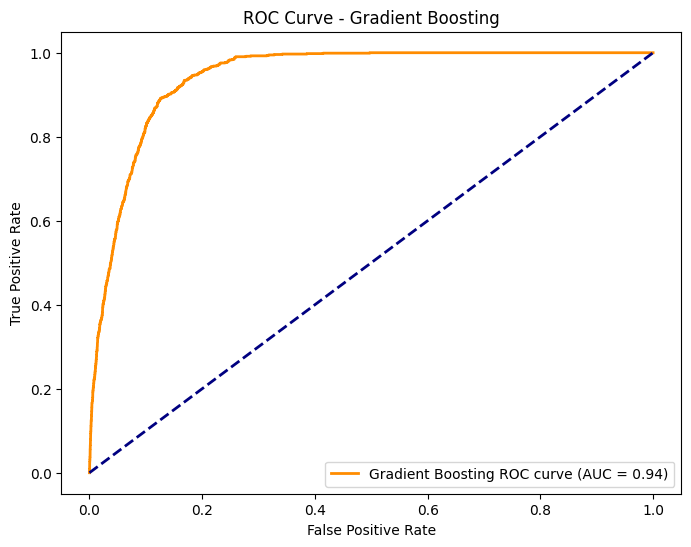


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87      7291
         1.0       0.35      0.97      0.52       944

    accuracy                           0.79      8235
   macro avg       0.67      0.87      0.69      8235
weighted avg       0.92      0.79      0.83      8235



In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

sample_weights = [weights[1] if label == 1 else weights[0]  for label in y_train]

gb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_prob_gb = gb.predict_proba(X_test_scaled)[:, 1]

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label='Gradient Boosting ROC curve (AUC = %0.2f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, gb.predict(X_test_scaled)))


**GradientBoost-Smote**

Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(



Confusion Matrix:
[[5607 1684]
 [  55  889]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87      7291
         1.0       0.35      0.94      0.51       944

    accuracy                           0.79      8235
   macro avg       0.67      0.86      0.69      8235
weighted avg       0.92      0.79      0.82      8235


ROC AUC Score: 0.91


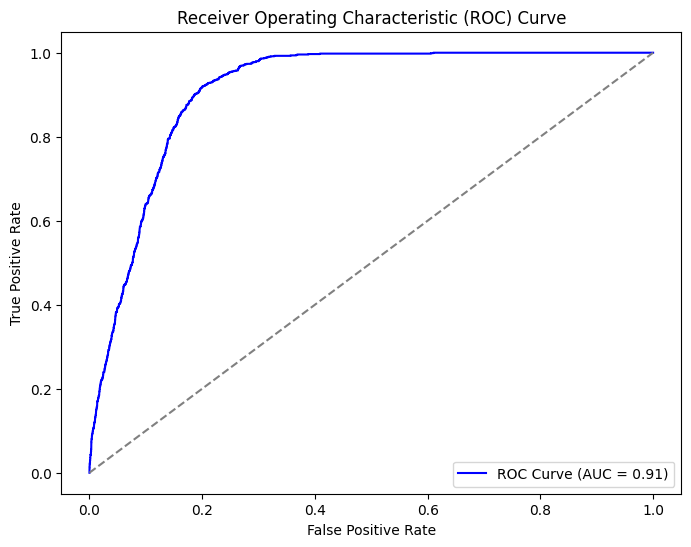

In [28]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBosst-RandomUnderSampling**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[5550 1741]
 [  26  918]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86      7291
         1.0       0.35      0.97      0.51       944

    accuracy                           0.79      8235
   macro avg       0.67      0.87      0.69      8235
weighted avg       0.92      0.79      0.82      8235


ROC AUC Score: 0.94


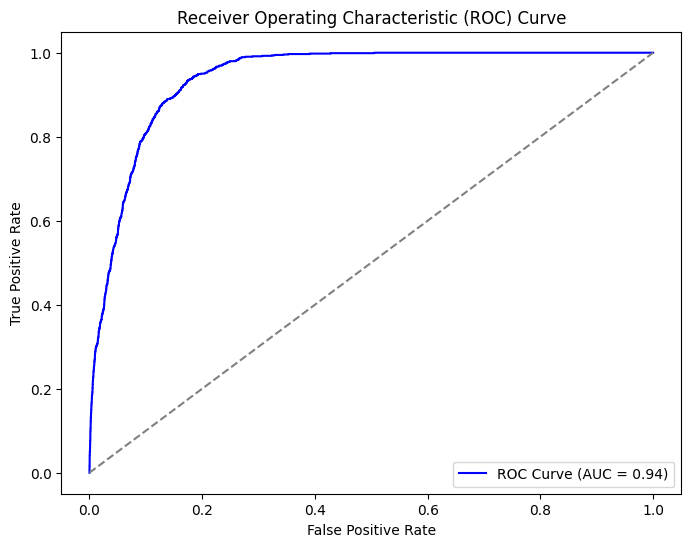

In [29]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**GradientBoost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [23604 27310]

Confusion Matrix:
[[5574 1717]
 [  34  910]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      7291
         1.0       0.35      0.96      0.51       944

    accuracy                           0.79      8235
   macro avg       0.67      0.86      0.69      8235
weighted avg       0.92      0.79      0.82      8235


ROC AUC Score: 0.93


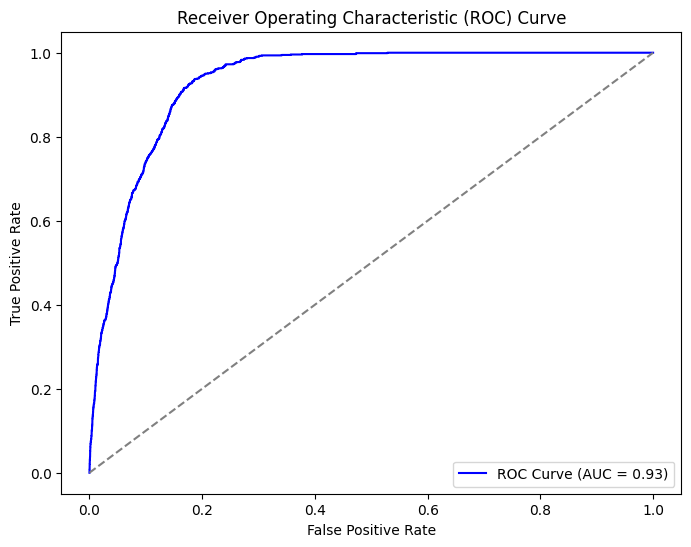

In [30]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_resampled, y_resampled)

y_pred = gb_clf.predict(X_test_scaled)
y_prob = gb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [31]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

gb_clf = GradientBoostingClassifier(random_state=42)
model4=gb_clf.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [23604 27310]


**CatBoost-Weighted Class**

Accuracy: 0.8216

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.80      0.89      7291
         1.0       0.39      0.95      0.55       944

    accuracy                           0.82      8235
   macro avg       0.69      0.88      0.72      8235
weighted avg       0.92      0.82      0.85      8235


Confusion Matrix:
[[5868 1423]
 [  46  898]]


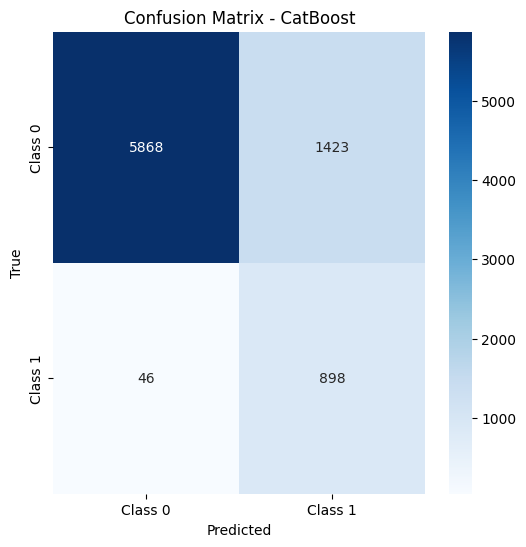

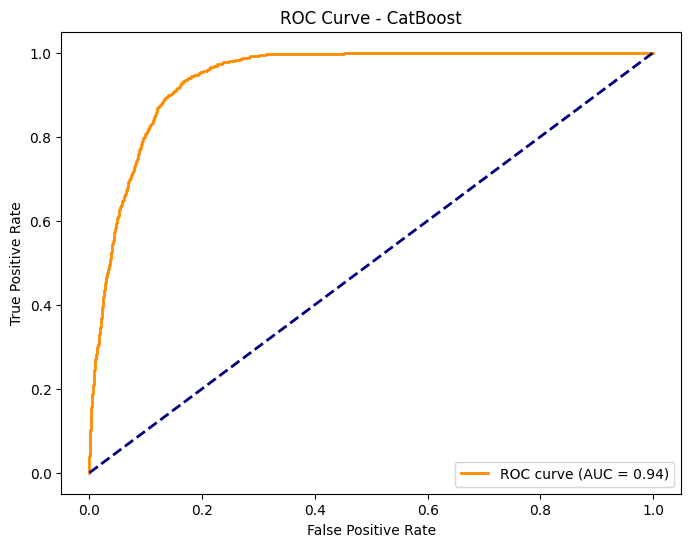

In [32]:


catboost_model = CatBoostClassifier(iterations=1000, class_weights=[weights[0],weights[1]], random_state=42, verbose=0)

catboost_model.fit(X_train_scaled, y_train)

y_pred_catboost = catboost_model.predict(X_test_scaled)

accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f"Accuracy: {accuracy_catboost:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_catboost))

conf_matrix_catboost = confusion_matrix(y_test, y_pred_catboost)
print("\nConfusion Matrix:")
print(conf_matrix_catboost)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix - CatBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
y_prob_catboost = catboost_model.predict_proba(X_test_scaled)[:, 1]

fpr_catboost, tpr_catboost, _ = roc_curve(y_test, y_prob_catboost)
roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_catboost)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost')
plt.legend(loc='lower right')
plt.show()


**CatBoost-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[5692 1599]
 [ 114  830]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87      7291
         1.0       0.34      0.88      0.49       944

    accuracy                           0.79      8235
   macro avg       0.66      0.83      0.68      8235
weighted avg       0.91      0.79      0.83      8235


ROC AUC Score: 0.89


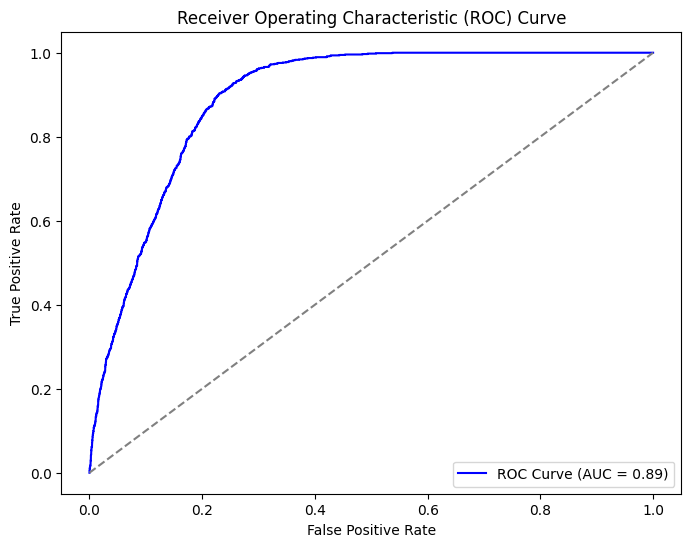

In [33]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


catboost_clf = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42, verbose=0)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**CatBoost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[5658 1633]
 [  22  922]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.87      7291
         1.0       0.36      0.98      0.53       944

    accuracy                           0.80      8235
   macro avg       0.68      0.88      0.70      8235
weighted avg       0.92      0.80      0.83      8235


ROC AUC Score: 0.94


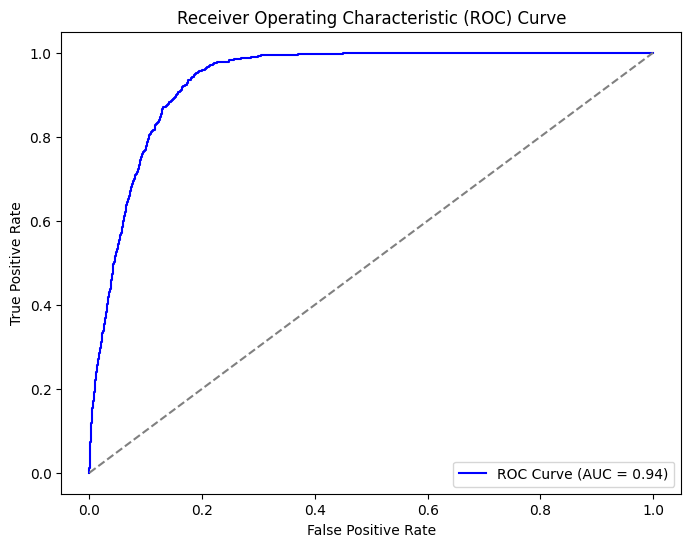

In [34]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**CatBoost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [23604 27310]

Confusion Matrix:
[[5782 1509]
 [  55  889]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      7291
         1.0       0.37      0.94      0.53       944

    accuracy                           0.81      8235
   macro avg       0.68      0.87      0.71      8235
weighted avg       0.92      0.81      0.84      8235


ROC AUC Score: 0.93


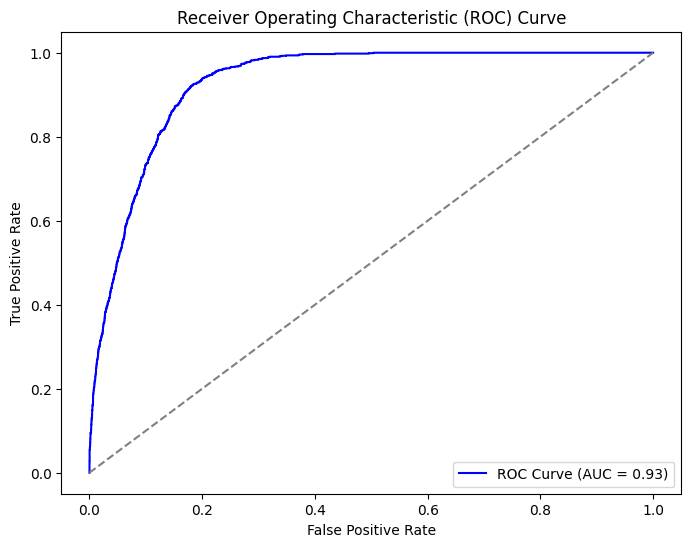

In [35]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


 **xgboost-weighted class**


Confusion Matrix:
[[5695 1596]
 [  29  915]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.88      7291
         1.0       0.36      0.97      0.53       944

    accuracy                           0.80      8235
   macro avg       0.68      0.88      0.70      8235
weighted avg       0.92      0.80      0.84      8235


ROC AUC Score: 0.94


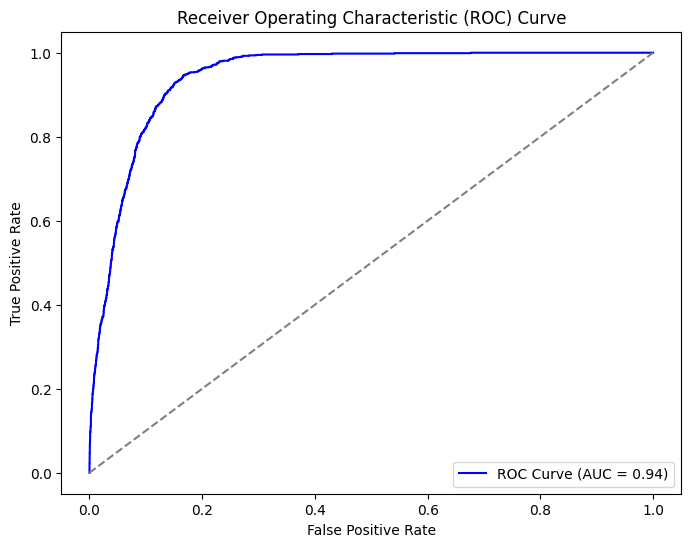

In [36]:
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_train_scaled, y_train)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Xgboost-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[5657 1634]
 [  65  879]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      7291
         1.0       0.35      0.93      0.51       944

    accuracy                           0.79      8235
   macro avg       0.67      0.85      0.69      8235
weighted avg       0.92      0.79      0.83      8235


ROC AUC Score: 0.90


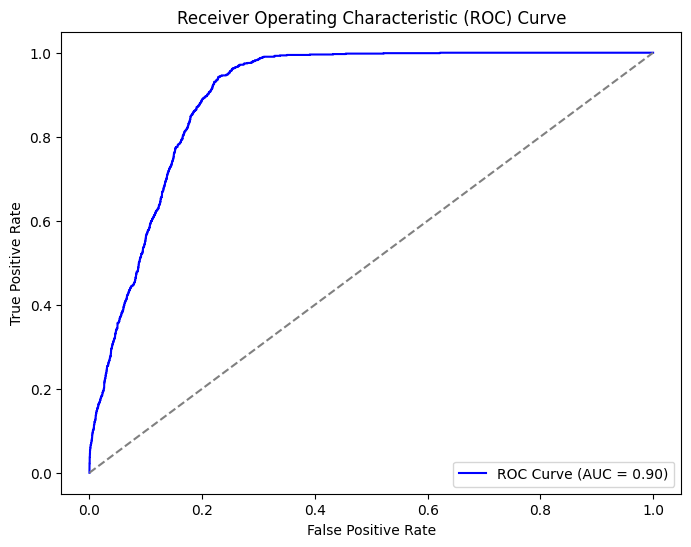

In [37]:



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")


xgb_clf = xgb.XGBClassifier(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Xgboost-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[5582 1709]
 [  25  919]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87      7291
         1.0       0.35      0.97      0.51       944

    accuracy                           0.79      8235
   macro avg       0.67      0.87      0.69      8235
weighted avg       0.92      0.79      0.83      8235


ROC AUC Score: 0.94


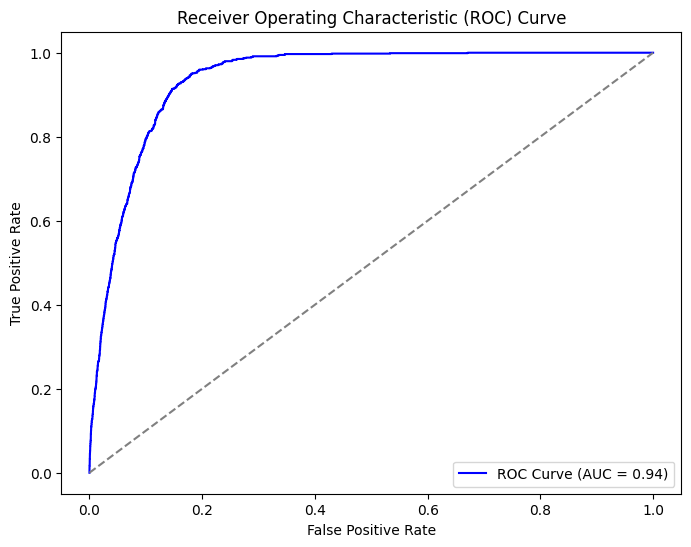

In [38]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
   random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Xgboost-Smoteenn**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [23604 27310]

Confusion Matrix:
[[5675 1616]
 [  42  902]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87      7291
         1.0       0.36      0.96      0.52       944

    accuracy                           0.80      8235
   macro avg       0.68      0.87      0.70      8235
weighted avg       0.92      0.80      0.83      8235


ROC AUC Score: 0.93


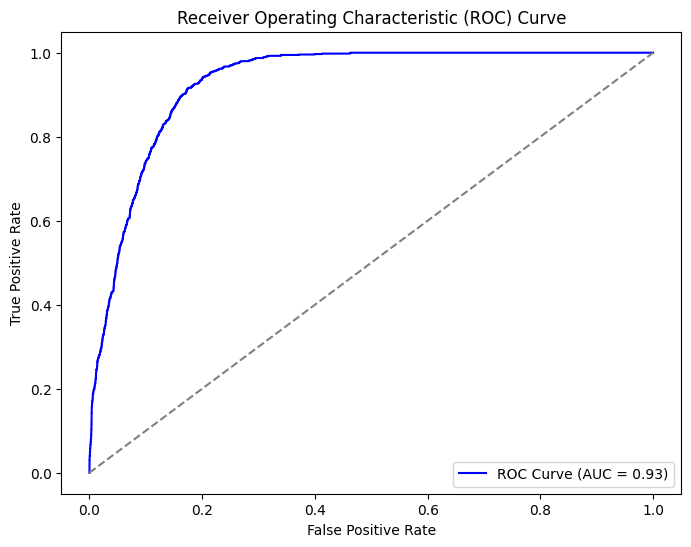

In [39]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

xgb_clf = xgb.XGBClassifier(
  random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

xgb_clf.fit(X_resampled, y_resampled)

y_pred = xgb_clf.predict(X_test_scaled)
y_prob = xgb_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


 **Random Forest-Weighted Class**


Confusion Matrix:
[[6947  344]
 [ 440  504]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95      7291
         1.0       0.59      0.53      0.56       944

    accuracy                           0.90      8235
   macro avg       0.77      0.74      0.75      8235
weighted avg       0.90      0.90      0.90      8235


ROC AUC Score: 0.94


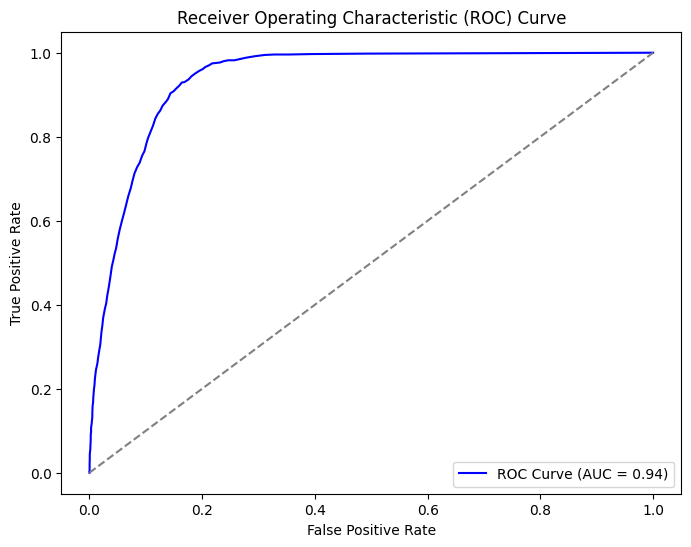

In [40]:


random_forest_clf = RandomForestClassifier(
    class_weight={0: weights[0],1: weights[1] },
    n_estimators=100,
    random_state=42
)

random_forest_clf.fit(X_train_scaled, y_train)

y_pred = random_forest_clf.predict(X_test_scaled)
y_prob = random_forest_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-Smote**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
SMOTE sonrası sınıf dağılımı: [29242 29242]

Confusion Matrix:
[[6375  916]
 [ 167  777]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.87      0.92      7291
         1.0       0.46      0.82      0.59       944

    accuracy                           0.87      8235
   macro avg       0.72      0.85      0.76      8235
weighted avg       0.92      0.87      0.88      8235


ROC AUC Score: 0.93


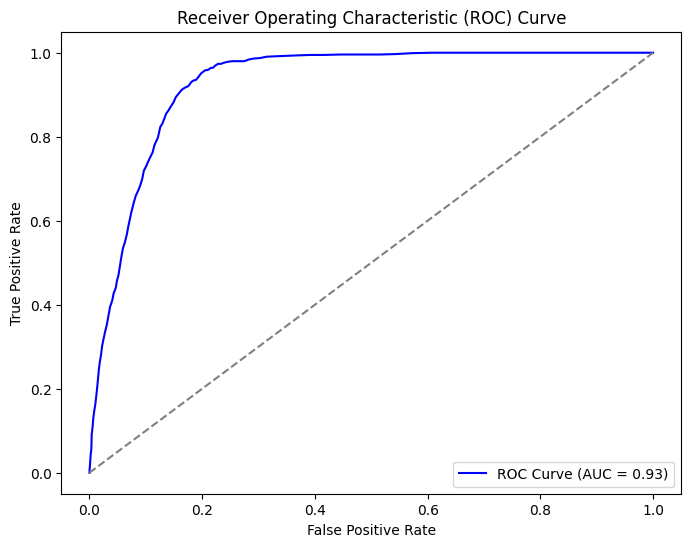

In [41]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTE sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

random_forest_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

random_forest_clf.fit(X_resampled, y_resampled)


y_pred = random_forest_clf.predict(X_test_scaled)
y_prob = random_forest_clf.predict_proba(X_test_scaled)[:, 1]
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-RandomUnderSampler**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[5608 1683]
 [  26  918]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87      7291
         1.0       0.35      0.97      0.52       944

    accuracy                           0.79      8235
   macro avg       0.67      0.87      0.69      8235
weighted avg       0.92      0.79      0.83      8235


ROC AUC Score: 0.93


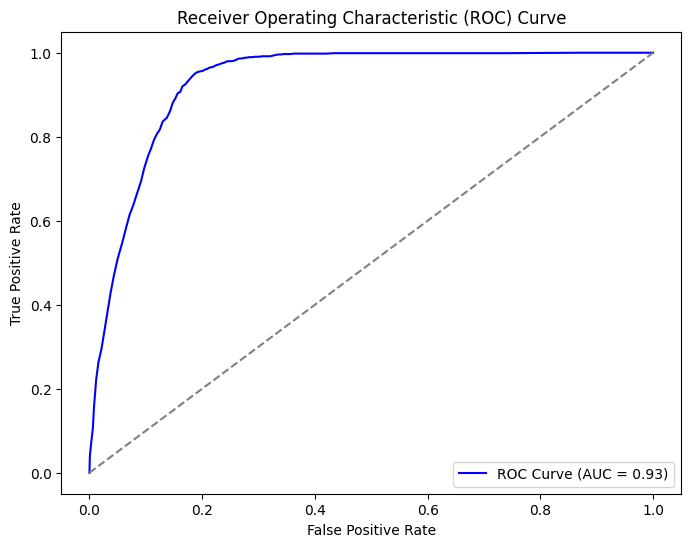

In [42]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_clf.fit(X_resampled, y_resampled)

y_pred = rf_clf.predict(X_test_scaled)
y_prob = rf_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**RandomForest-Smoteen**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTEENN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Orijinal sınıf dağılımı: [29242  3695]
SMOTEENN sonrası sınıf dağılımı: [23604 27310]

Confusion Matrix:
[[6089 1202]
 [  77  867]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.90      7291
         1.0       0.42      0.92      0.58       944

    accuracy                           0.84      8235
   macro avg       0.70      0.88      0.74      8235
weighted avg       0.92      0.84      0.87      8235


ROC AUC Score: 0.93


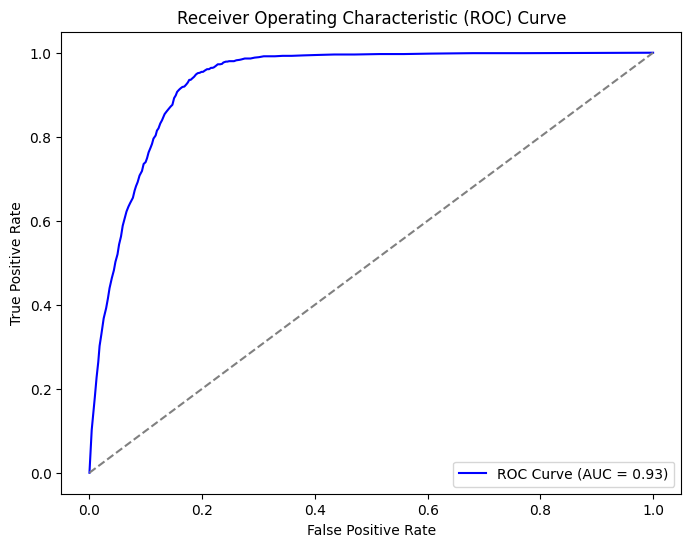

In [43]:

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"SMOTEENN sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_clf.fit(X_resampled, y_resampled)

y_pred = rf_clf.predict(X_test_scaled)
y_prob = rf_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# **Neural Networks**

**Focal Loss**

In [44]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [45]:
import tensorflow as tf
def focal_loss(alpha=0.9090367403237989, gamma=4.202187396549279):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = y_true * (1 - y_pred)**gamma + (1 - y_true) * y_pred**gamma
        return tf.reduce_mean(alpha * weight * cross_entropy)
    return loss


model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss=focal_loss(alpha=0.9090367403237989, gamma=4.202187396549279),
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=16
)

test_loss, test_accuracy, test_recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Recall: {test_recall:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.8146 - loss: 0.0240 - recall: 0.2303 - val_accuracy: 0.9087 - val_loss: 0.0127 - val_recall: 0.4280
Epoch 2/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9030 - loss: 0.0126 - recall: 0.3134 - val_accuracy: 0.9087 - val_loss: 0.0128 - val_recall: 0.5318
Epoch 3/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9065 - loss: 0.0121 - recall: 0.3607 - val_accuracy: 0.8991 - val_loss: 0.0121 - val_recall: 0.6568
Epoch 4/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9081 - loss: 0.0111 - recall: 0.4284 - val_accuracy: 0.9059 - val_loss: 0.0114 - val_recall: 0.6261
Epoch 5/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9074 - loss: 0.0108 - recall: 0.4584 - val_accuracy: 0.9059 - val_loss: 0.0110 - val_recall: 0.5551
Epoch 6/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9063 - loss: 0.0107 - recall: 0.4404 - val_accuracy: 0.9002 - val_loss: 0.0121 - val_reca

In [46]:
import optuna
from sklearn.metrics import recall_score

def objective(trial):
    alpha = trial.suggest_float("alpha", 0.1, 1.0)
    gamma = trial.suggest_float("gamma", 1.0, 5.0)

    model.compile(optimizer='adam', loss=focal_loss(alpha=alpha, gamma=gamma), metrics=['accuracy'])
    model.fit(X_train_scaled, y_train, epochs=10, batch_size=16, verbose=0)

    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
    return recall_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print(f"Best Parameters: {study.best_params}")


[I 2025-01-01 20:54:51,767] A new study created in memory with name: no-name-4c238072-171b-4897-8ffb-0dbb0d096d4c


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-01 20:55:56,175] Trial 0 finished with value: 0.6154661016949152 and parameters: {'alpha': 0.9031543258011163, 'gamma': 2.9242361155198098}. Best is trial 0 with value: 0.6154661016949152.


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-01 20:56:44,935] Trial 1 finished with value: 0.625 and parameters: {'alpha': 0.1585733834860092, 'gamma': 1.7252616694351737}. Best is trial 1 with value: 0.625.


258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-01 20:57:29,445] Trial 2 finished with value: 0.4427966101694915 and parameters: {'alpha': 0.4815124634076151, 'gamma': 3.8515627377898998}. Best is trial 1 with value: 0.625.


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-01 20:58:17,000] Trial 3 finished with value: 0.6461864406779662 and parameters: {'alpha': 0.2543779234740727, 'gamma': 2.8636767371981193}. Best is trial 3 with value: 0.6461864406779662.


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-01 20:58:57,689] Trial 4 finished with value: 0.7478813559322034 and parameters: {'alpha': 0.5554843607381157, 'gamma': 3.5428017825627416}. Best is trial 4 with value: 0.7478813559322034.


Best Parameters: {'alpha': 0.5554843607381157, 'gamma': 3.5428017825627416}


In [48]:
def focal_loss(alpha=0.5554843607381157, gamma=3.5428017825627416):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = y_true * (1 - y_pred)**gamma + (1 - y_true) * y_pred**gamma
        return tf.reduce_mean(alpha * weight * cross_entropy)
    return loss


model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss=focal_loss(alpha=0.5554843607381157, gamma=3.5428017825627416),
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=16
)

test_loss, test_accuracy, test_recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Recall: {test_recall:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8929 - loss: 0.0160 - recall_2: 0.1266 - val_accuracy: 0.9041 - val_loss: 0.0115 - val_recall_2: 0.5297
Epoch 2/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9066 - loss: 0.0110 - recall_2: 0.4000 - val_accuracy: 0.9001 - val_loss: 0.0107 - val_recall_2: 0.5191
Epoch 3/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9086 - loss: 0.0107 - recall_2: 0.4234 - val_accuracy: 0.9003 - val_loss: 0.0115 - val_recall_2: 0.6610
Epoch 4/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9094 - loss: 0.0102 - recall_2: 0.4346 - val_accuracy: 0.8982 - val_loss: 0.0117 - val_recall_2: 0.6377
Epoch 5/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9101 - loss: 0.0102 - recall_2: 0.4324 - val_accuracy: 0.9070 - val_loss: 0.0102 - val_recall_2: 0.5064
Epoch 6/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9133 - loss: 0.0100 - recall_2: 0.4412 - val_accuracy: 0.9013 - val_loss

**Weighted Binary Crossentropy**

In [51]:
import tensorflow as tf
def weighted_binary_crossentropy(weight):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        weights_vec = y_true * weight[1] + (1 - y_true) * weight[0]
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        return tf.reduce_mean(weights_vec * bce)
    return loss


model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss=weighted_binary_crossentropy(weight=[weights[0], weights[1]]),
    metrics=['accuracy', tf.keras.metrics.Recall()]
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=20,
    batch_size=16
)

test_loss, test_accuracy, test_recall = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Recall: {test_recall:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8710 - loss: 0.7511 - recall_4: 0.1084 - val_accuracy: 0.9060 - val_loss: 0.4832 - val_recall_4: 0.5117
Epoch 2/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9079 - loss: 0.4755 - recall_4: 0.4386 - val_accuracy: 0.8927 - val_loss: 0.5034 - val_recall_4: 0.7267
Epoch 3/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9125 - loss: 0.4468 - recall_4: 0.5202 - val_accuracy: 0.8922 - val_loss: 0.4724 - val_recall_4: 0.7119
Epoch 4/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9061 - loss: 0.4489 - recall_4: 0.5511 - val_accuracy: 0.8919 - val_loss: 0.4699 - val_recall_4: 0.7076
Epoch 5/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9089 - loss: 0.4483 - recall_4: 0.5409 - val_accuracy: 0.8832 - val_loss: 0.4878 - val_recall_4: 0.7871
Epoch 6/20
2059/2059 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9113 - loss: 0.4285 - recall_4: 0.5902 - val_accuracy: 0.8986 - val_lo

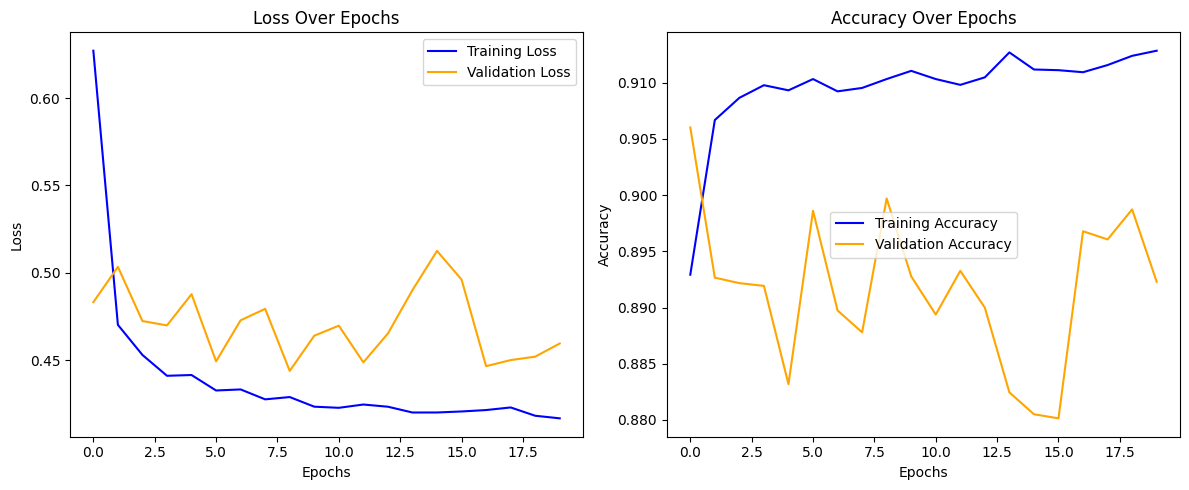

In [52]:


def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


# **Best Model Feature Selection**

In [53]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)
best_model=catboost_clf.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]


In [54]:
feature_importance=best_model.feature_importances_
cat_fi_df=pd.DataFrame({"Feature" : X.columns, "Importance": feature_importance})
cat_fi_df=cat_fi_df.sort_values(by="Importance",ascending=False)
cat_fi_df


,Feature,Importance
10,duration,29.942931
17,euribor3m*emp.var.rate*nr.employed,24.225243
0,age,6.902540
16,cons.conf.idx,5.880410
8,month,4.563325
1,job,3.867523
11,campaign,3.629163
9,day_of_week,3.551825
3,education,3.263140
15,cons.price.idx,3.146408


In [63]:
Selected_Features=list(cat_fi_df[cat_fi_df["Importance"]>3].Feature)

In [64]:
Selected_Features.append("y")

In [65]:
df_new=df[Selected_Features]
df_new.head()

,duration,euribor3m*emp.var.rate*nr.employed,age,cons.conf.idx,month,job,campaign,day_of_week,education,cons.price.idx,y
0,261.0,27733.9557,56.0,-36.4,6.0,3.0,1.0,1.0,0.0,93.994,0.0
1,149.0,27733.9557,57.0,-36.4,6.0,8.0,1.0,1.0,3.0,93.994,0.0
2,226.0,27733.9557,37.0,-36.4,6.0,8.0,1.0,1.0,3.0,93.994,0.0
3,151.0,27733.9557,40.0,-36.4,6.0,0.0,1.0,1.0,1.0,93.994,0.0
4,307.0,27733.9557,56.0,-36.4,6.0,8.0,1.0,1.0,3.0,93.994,0.0


In [66]:
X=df_new.drop("y",axis=1)
y=df_new["y"]

In [67]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [68]:
scaler=MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Orijinal sınıf dağılımı: [29242  3695]
RUS sonrası sınıf dağılımı: [3695 3695]

Confusion Matrix:
[[6220 1071]
 [  60  884]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92      7291
         1.0       0.45      0.94      0.61       944

    accuracy                           0.86      8235
   macro avg       0.72      0.89      0.76      8235
weighted avg       0.93      0.86      0.88      8235


ROC AUC Score: 0.94


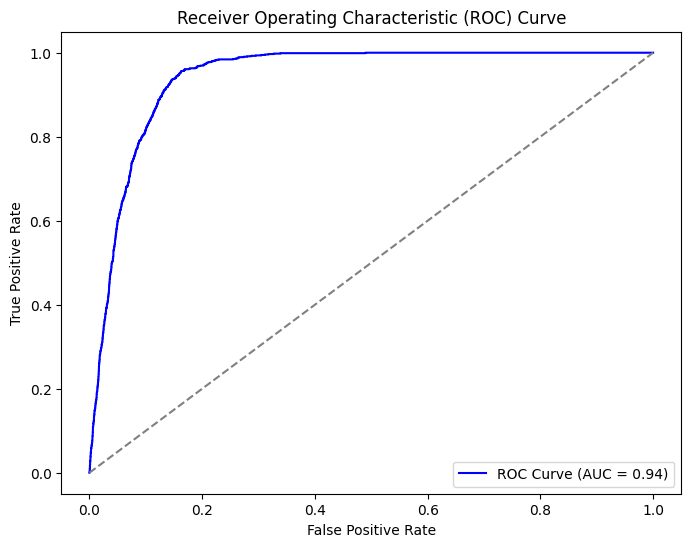

In [69]:

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)

print(f"Orijinal sınıf dağılımı: {np.bincount(y_train)}")
print(f"RUS sonrası sınıf dağılımı: {np.bincount(y_resampled)}")

catboost_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0
)
catboost_clf.fit(X_resampled, y_resampled)

y_pred = catboost_clf.predict(X_test_scaled)
y_prob = catboost_clf.predict_proba(X_test_scaled)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_auc:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
